In [2]:
import os

import numpy as np
import pandas as pd

from source.processes import Shuffler
from source.datamodels.datamodels import GridSearchResults
from source.datamodels.datamodels import Axes, Stats

In [3]:
project_folder = "F:/PythonNotebooks/Study/Quantum/Bearings/"
own_data_path = os.path.join(project_folder, "data/own datasets/")
third_party_data_path = os.path.join(project_folder, "data/third party datasets/")

In [4]:
prepared_data = pd.read_csv(os.path.join(own_data_path, 'processed_full_signal_specter1000_noscale.csv'), delimiter=',')  # our experiment
# prepared_data = pd.read_csv(os.path.join(third_party_data_path, 'N1 Cesar Ricardo', 'csv',
#                                          'processed_full_signal_specter1000_noscale.csv'), delimiter=',')  # third-party dataset
prepared_data.head()

,target,group,a1_x_signal_complexity,a1_x_signal_shannon_entropy,a1_x_signal_kurtosis,a1_x_signal_variation,a1_x_signal_hurst,a1_x_signal_skew,a1_x_signal_activity,a1_x_signal_iqr,...,a2_z_specter_iqr,a2_z_specter_zero_crossing,a2_z_specter_range,a2_z_specter_mean,a2_z_specter_petrosian_fd,a2_z_specter_higuchi_fd,a2_z_specter_crest_factor,a2_z_specter_energy,a2_z_specter_std,a2_z_specter_sample_entropy
0,0.0,1.0,1.865568,6.388020,-0.337526,-9.989303,0.626170,-0.231906,0.519530,3.006134,...,130.212247,0.0,430.516204,121.609951,1.024136,1.709899,2.865578,2.261059e+07,88.439848,2.754299
1,0.0,1.0,1.812863,6.507361,-0.329388,-8.479932,0.633813,0.046480,0.519920,3.270674,...,79.932721,0.0,339.669032,116.951076,1.024806,1.754620,2.630547,1.683235e+07,56.167537,2.881832
2,0.0,1.0,1.775775,6.489806,-0.439591,-9.585973,0.625745,0.014204,0.531458,3.174478,...,87.487539,0.0,359.727237,126.969372,1.022686,1.718792,2.593399,1.971760e+07,59.969811,2.874073
3,0.0,1.0,1.912905,6.422261,-0.364524,-9.033494,0.606942,-0.145760,0.512090,2.982085,...,78.688634,0.0,353.579137,108.447712,1.025371,1.746161,2.880197,1.547513e+07,60.944452,2.780298
4,0.0,1.0,1.868826,6.449559,0.017384,-8.482620,0.631058,-0.149621,0.526677,2.982085,...,83.595954,0.0,331.560162,112.269206,1.024240,1.762398,2.665190,1.596652e+07,57.984006,2.852191


In [5]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [6]:
LR_estimator = LogisticRegression(max_iter=10000)
SVC_estimator = SVC()
RFC_estimator = RandomForestClassifier()
GBM_estimator = GradientBoostingClassifier()
KNN_estimator = KNeighborsClassifier()

In [7]:
LR_grid = {"C": np.logspace(-3, 6, 10)}
SVC_grid = {"C": np.logspace(-3, 6, 10), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
RFC_grid = {'n_estimators': [20, 50, 100, 200, 500], 'max_depth': [1, 3, 5, 9, 15, 30, None]}
GBM_grid = {'learning_rate': np.logspace(-3, 4, 8), 'n_estimators': [50, 100, 200, 500], 'max_depth': [1, 3, 5, 9, 15, 30, None]}
KNN_grid = {'n_neighbors': [1, 3, 5, 7, 9, 15, 35], 'p': [1, 1.5, 2, 2.5, 6, 100]}

In [8]:
X = prepared_data.drop(columns=['target', 'group']).values
y = prepared_data['target'].values
groups = prepared_data['group'].values

X_scaled = StandardScaler().fit_transform(X)

In [13]:
from datetime import datetime

GS_results_objects = []
estimators = [LR_estimator, SVC_estimator]
grids = [LR_grid, SVC_grid]
names = ['LR', 'SVC']
score_name = 'f1'

for estimator, grid, name in zip(estimators, grids, names):
    start_time = datetime.now()
    cv = Shuffler.OverlapGroupCV(train_size=0.63, n_repeats=100).split(X_scaled, y, groups)
    GSCV = GridSearchCV(estimator, grid, scoring=score_name, cv=cv)
    GSCV.fit(X_scaled, y, groups=groups)

    print(f"Best {score_name} score for {name}: {100*GSCV.best_score_:.3f}% \n best params: {GSCV.best_params_}\n required time: {datetime.now() - start_time}")

    highest_score_params = GSCV.cv_results_['rank_test_score'][0]
    split_scores_names = [f'split{idx}_test_score' for idx in range(100)]

    scores_distr = []
    for split_scores_name in split_scores_names:
        scores_distr.append(GSCV.cv_results_[split_scores_name][highest_score_params-1])
    res = GridSearchResults(
        run_label = "GS",
        model_name = name,
        hyperparameters = GSCV.best_params_,
        hyperparameters_grid = grid,
        use_signal = True,
        use_specter = True,
        specter_threshold = 1000,
        axes = Axes.get_keys(),
        stats = Stats.get_keys(),
        predictions = None,
        scores = {score_name: GSCV.best_score_},
        resampling_number = 100,
        bootstrap_scores =  {score_name: scores_distr}
    )
    GS_results_objects.append(res)

Best f1 score for LR: 84.988% 
 best params: {'C': 10000.0}
 required time: 0:00:32.077942
Best f1 score for SVC: 85.250% 
 best params: {'C': 0.1, 'kernel': 'linear'}
 required time: 0:01:40.415973


In [17]:
GS_results_objects

[GridSearchResults(run_label='GS', model_name='LR', hyperparameters={'C': 10000.0}, use_signal=True, use_specter=True, specter_threshold=1000, axes=['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z'], stats=['mean', 'std', 'kurtosis', 'skew', 'variation', 'range', 'iqr', 'sample_entropy', 'shannon_entropy', 'energy', 'hurst', 'petrosian_fd', 'zero_crossing', 'higuchi_fd', 'activity', 'complexity', 'crest_factor'], predictions=None, scores={'f1': 0.8498766688063649}, resampling_number=100, bootstrap_scores={'f1': [0.8602150537634408, 0.8505747126436781, 0.970873786407767, 0.6835443037974683, 0.8723404255319149, 0.99009900990099, 0.7706422018348624, 0.9702970297029702, 0.9183673469387755, 0.7000000000000001, 0.6516853932584269, 0.8275862068965518, 0.9292929292929293, 0.9333333333333333, 0.9052631578947369, 0.8723404255319149, 0.888888888888889, 0.853932584269663, 0.8775510204081632, 0.9010989010989011, 0.7407407407407407, 0.7499999999999999, 0.8659793814432989, 0.9010989010989011, 0.9306930

In [ ]:
from source.postprocessing.mljson import serialize_results


serialize_results(GS_results_objects, filenames=[f"{model}_GS_28_10_2021.json" for model in names], filepath=os.path.join(project_folder, 'experiments/BootstrapsRuns/GridSearch/'))

In [14]:
estimators_score_distr = [res.bootstrap_scores for res in GS_results_objects]
estimators_scores_means = [res.scores for res in GS_results_objects]

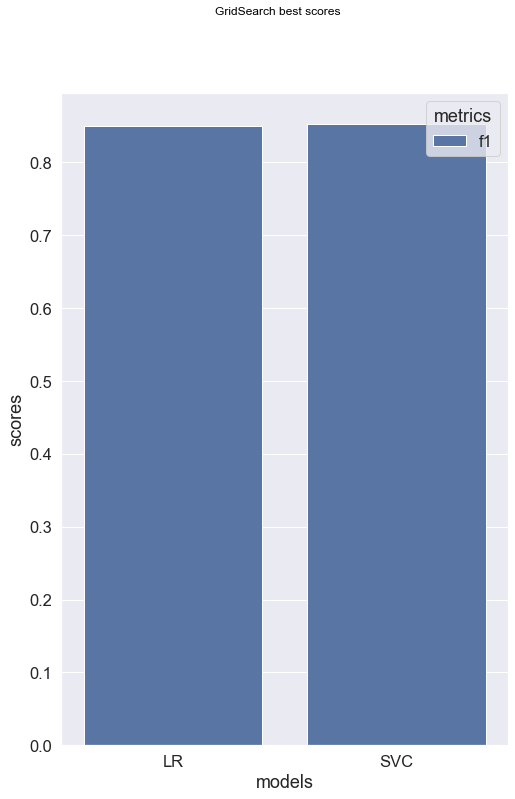

In [15]:
from source.postprocessing.plotter import dist_plot, bar_plot


# dist_plot(results=estimators_score_distr, models=names, metrics=['f1'], plot_size=(8, 12), Title='GridSearch', filename='GS_LR_SVC.png')

bar_plot(results=estimators_scores_means, models=names, metrics=['f1'], plot_size=(8, 12), Title='GridSearch best scores', filename='GS_LR_SVC_means.png')